# Red Wine Quality

Here, we are looking at the quality of red wines, as listed on [Kaggle](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009). We have a set number of classes (0-10) a quality score can belong to, so we are facing a classification problem. Let us start with understanding the data a bit better.

In [109]:
import numpy as np
import pandas as pd



In [2]:
df = pd.read_csv(r'winequality-red.csv')
print(df.info())

NUM_WINES, NUM_VARIABLES = df.shape
QUALITY = NUM_VARIABLES-1
NUM_SCORES = 10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [3]:
# Any missing data?
df.isnull().values.any()

False

What does the data look like? Can we see what the quality scores are and how many there are for each score? Are there any relations between the variables that are immediately clear from the covariance matrix?

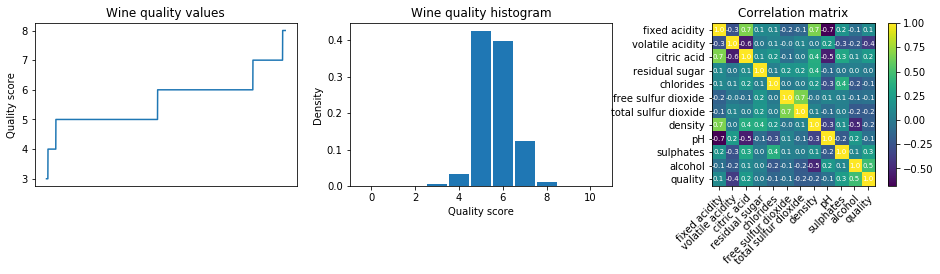

In [73]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

# Move the dataframe to a numpy array
data = df.to_numpy()

# Extract a few metrics: the quality levels, the unique quality scores and their numbers, ...
qualities = data[:, QUALITY].astype(np.int)
(unique_qualities, counts) = np.unique(qualities, return_counts=True)

NUM_UNQ_Q = len(unique_qualities)

# Sort data
data_idx = qualities.argsort()
qualities = qualities[data_idx]
data = data[data_idx]

idx_sorted = np.arange(NUM_WINES)
idx_unsorted = np.asarray(data_idx)

idx_trnsfrmd = idx_sorted.copy()
idx_trnsfrmd[idx_unsorted] = idx_sorted

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(16,3))

# Show the increasing quality scores
ax[0].set_title('Wine quality values')
ax[0].set_ylabel('Quality score')
ax[0].set_xticks([])
ax[0].plot(idx_sorted, data[:, QUALITY]);

# Show the frequency of each score
ax[1].set_title('Wine quality histogram')
ax[1].set_xlabel('Quality score')
ax[1].set_ylabel('Density')
ax[1].hist(data[:, QUALITY], bins=np.arange(NUM_VARIABLES), density=True, align='left', rwidth=0.9)

# Show the correlations
C = np.corrcoef(data.T)
ax[2].set_title('Correlation matrix')
ax[2].set_xticks(range(NUM_VARIABLES))
ax[2].set_xticklabels(df.columns)
plt.setp(ax[2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

#ax[2].yaxis.tick_right()
ax[2].set_yticks(range(NUM_VARIABLES))
ax[2].set_yticklabels(df.columns)
for i in range(NUM_VARIABLES):
    for j in range(NUM_VARIABLES):
        text = ax[2].text(j, i, C[i, j].round(1), ha="center", va="center", color="w", fontsize=7)
imshw = ax[2].imshow(C);
plt.colorbar(imshw, ax=ax[2]);


In [69]:
quality_weights = NUM_WINES/(NUM_SCORES*counts)

sample_weights = np.zeros(qualities.shape)
for i, weight in zip(unique_qualities, quality_weights):
    idx = qualities == i
    sample_weights[qualities == i] = weight
    

It seems like the aclohol and the volatile acidity correlate the most with the score. Now, how does the PCA of this data look like? We can use the components to plot our future classifications. It seems like the second and third components yield the best plot.

Variance per component = [0.26009731 0.1868235  0.14024331 0.10125174] , total =  0.6884158587471418


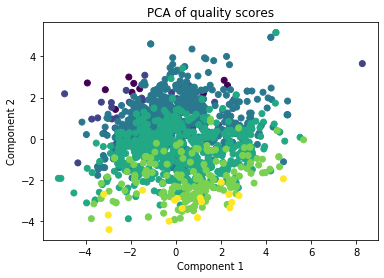

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

from sklearn.decomposition import PCA
pca = PCA(n_components=4)
data_pca = pca.fit_transform(data_scaled)
print('Variance per component =', pca.explained_variance_ratio_, ', total = ', sum(pca.explained_variance_ratio_))

plt.figure()
plt.title('PCA of quality scores')
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.scatter(data_pca[:,0], data_pca[:, 1], c=qualities);


## Create a test-train split
Simply take the first 11 columns as observations and the *quality* column as targets.

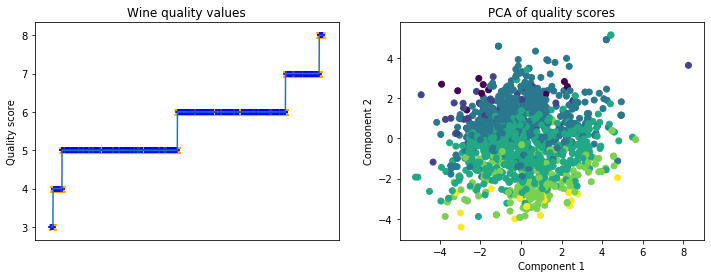

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        data[:, 0:(NUM_VARIABLES-1)], data[:, NUM_VARIABLES-1], idx_unsorted,
        test_size=0.25, random_state=23, shuffle=True)

y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)

NUM_TRAIN = idx_train.size
NUM_TEST = idx_test.size

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].set_title('Wine quality values')
ax[0].set_ylabel('Quality score')
ax[0].set_xticks([])
ax[0].plot(idx_sorted, data[:, QUALITY])

y_train_idx = np.argsort(y_train)
x = idx_trnsfrmd[idx_train[y_train_idx]]
ax[0].scatter(x, y_train[y_train_idx], c='orange', marker='x')

y_test_idx = np.argsort(y_test)
x = idx_trnsfrmd[idx_test[y_test_idx]]
ax[0].scatter(x, y_test[y_test_idx], c='blue', marker='+')

ax[1].set_title('PCA of quality scores')
ax[1].set_xlabel("Component 1")
ax[1].set_ylabel("Component 2")
ax[1].scatter(data_pca[idx_test[y_test_idx], 0], data_pca[idx_test[y_test_idx], 1], c=data[idx_test[y_test_idx], QUALITY]);
ax[1].scatter(data_pca[idx_train[y_train_idx], 0], data_pca[idx_train[y_train_idx], 1], c=data[idx_train[y_train_idx], QUALITY]);


In [80]:
train_weights = sample_weights[idx_trnsfrmd[idx_train]]
test_weights = sample_weights[idx_trnsfrmd[idx_test]]
assert train_weights.size == NUM_TRAIN
assert test_weights.size == NUM_TEST

In [100]:
from sklearn.metrics import accuracy_score, f1_score

def score(y_train_true, y_train_predicted, y_test_true, y_test_predicted):
    trs = round(accuracy_score(y_train_true, y_train_predicted)*100, 0)
    trf = round(f1_score(y_train_true, y_train_predicted, labels=unique_qualities,
                         average='weighted', sample_weight=train_weights), 2)
    print(f'Train: acc = {trs}%, f1 = {trf}')
    tss = round(accuracy_score(y_test_true, y_test_predicted)*100, 0)
    tsf = round(f1_score(y_test_true, y_test_predicted, labels=unique_qualities,
                         average='weighted', sample_weight=test_weights), 2)
    print(f'Test:  acc = {tss}%, f1 = {tsf}')

## Simple Logistic Regression Model

Train: acc = 45.0%, f1 = 0.46
Test:  acc = 42.0%, f1 = 0.52


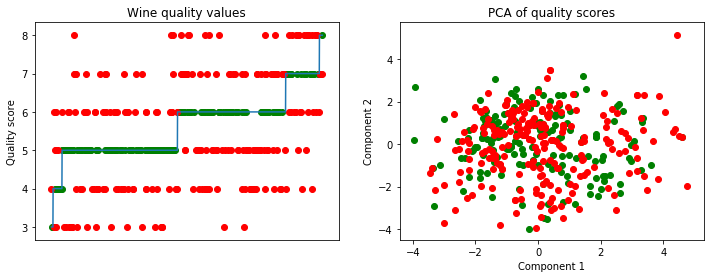

In [101]:
from sklearn.linear_model import LogisticRegression

model_weights = {q: w for q, w in zip(unique_qualities, weights)}
model = LogisticRegression(solver='lbfgs', multi_class='auto', C=0.9, max_iter=100, class_weight=model_weights)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

score(y_train, model.predict(X_train), y_test, y_predict)

correct_idx = (y_predict == y_test)
incorrect_idx = (y_predict != y_test)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].set_title('Wine quality values')
ax[0].set_ylabel('Quality score')
ax[0].set_xticks([])
ax[0].plot(np.arange(NUM_WINES), data[:, QUALITY])
ax[0].scatter(idx_trnsfrmd[idx_test[correct_idx]], y_predict[correct_idx], c='green');
ax[0].scatter(idx_trnsfrmd[idx_test[incorrect_idx]], y_predict[incorrect_idx], c='red');

ax[1].set_title('PCA of quality scores')
ax[1].set_xlabel("Component 1")
ax[1].set_ylabel("Component 2")
ax[1].scatter(data_pca[idx_test[correct_idx], 0], data_pca[idx_test[correct_idx], 1], c='green');
ax[1].scatter(data_pca[idx_test[incorrect_idx], 0], data_pca[idx_test[incorrect_idx], 1], c='red');


{'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 22, 'weights': 'distance'}
KNeighborsClassifier(algorithm='ball_tree', leaf_size=20, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=22, p=2,
                     weights='distance')
Train: acc = 100.0%, f1 = 1.0
Test:  acc = 68.0%, f1 = 0.58


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


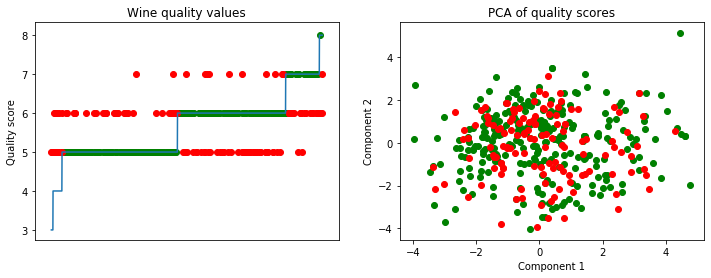

In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':range(2, 30, 10), 'leaf_size':range(20, 50, 5), 
              'algorithm':('ball_tree', 'kd_tree', 'brute'), 'weights': ('uniform', 'distance')}
clf = GridSearchCV(model, parameters, scoring='accuracy', cv=5, n_jobs=-1)
clf.iid = True
clf.fit(X_train, y_train)

print(clf.best_params_)
model.n_neighbors = clf.best_params_['n_neighbors']
model.leaf_size = clf.best_params_['leaf_size']
model.algorithm = clf.best_params_['algorithm']
model.weights = clf.best_params_['weights']
print(model)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

correct_idx = (y_predict == y_test)
incorrect_idx = (y_predict != y_test)

score(y_train, model.predict(X_train), y_test, y_predict)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].set_title('Wine quality values')
ax[0].set_ylabel('Quality score')
ax[0].set_xticks([])
ax[0].plot(np.arange(NUM_WINES), data[:, QUALITY])
ax[0].scatter(idx_trnsfrmd[idx_test[correct_idx]], y_predict[correct_idx], c='green');
ax[0].scatter(idx_trnsfrmd[idx_test[incorrect_idx]], y_predict[incorrect_idx], c='red');

ax[1].set_title('PCA of quality scores')
ax[1].set_xlabel("Component 1")
ax[1].set_ylabel("Component 2")
ax[1].scatter(data_pca[idx_test[correct_idx], 0], data_pca[idx_test[correct_idx], 1], c='green');
ax[1].scatter(data_pca[idx_test[incorrect_idx], 0], data_pca[idx_test[incorrect_idx], 1], c='red');


## Complex Machine Learning model

In [10]:
import torch

cuda = torch.cuda.is_available()
torch.backends.cudnn.benchmark = True

if cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

home = torch.device("cpu")
print(device, home)

cpu cpu


In [11]:
class ClassifierNet(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(ClassifierNet, self).__init__()
        self.activation = torch.nn.ReLU()
        self.L1         = torch.nn.Linear(inputSize, 64)
        self.L2         = torch.nn.Linear(64, 128)
        self.L3         = torch.nn.Linear(128, 64)
        self.L4         = torch.nn.Linear(64, outputSize)
        
        self.dropout    = torch.nn.Dropout(p=0.4)
        self.bn_1 = torch.nn.BatchNorm1d(64)
        self.bn_2 = torch.nn.BatchNorm1d(128)
        self.bn_3 = torch.nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.activation(self.L1(x))
        x = self.dropout(x)
        x = self.activation(self.bn_2(self.L2(x)))
        x = self.activation(self.bn_3(self.L3(x)))
        x = self.L4(x)
        return x

In [12]:
model = ClassifierNet(NUM_VARIABLES-1, NUM_SCORES)
model.double()

criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=0.001)

In [13]:
if isinstance(X_train, np.ndarray):
    X_train = torch.from_numpy(X_train).to(device)
    y_train = torch.from_numpy(y_train).to(device)

    X_test = torch.from_numpy(X_test).to(device)
    y_test = torch.from_numpy(y_test).to(device)

In [14]:
from torch.autograd import Variable
from tqdm import tqdm

model.train()
if cuda:
    model = model.cuda()
    
losses = []
training_accuracy = []
testing_accuracy = []

inputs = Variable(X_train)
labels = Variable(y_train)
    
epochs = 100
test_epoch = int(epochs/50)
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if epoch % test_epoch == 0:
        train_acc = accuracy_score(y_train.to(home), torch.argmax(outputs.to(home), dim=1))
        training_accuracy.append(train_acc)
        
        outputs = model(Variable(X_test.to(device)))
        test_acc = accuracy_score(y_test.to(home), torch.argmax(outputs.to(home), dim=1))
        testing_accuracy.append(test_acc)

100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


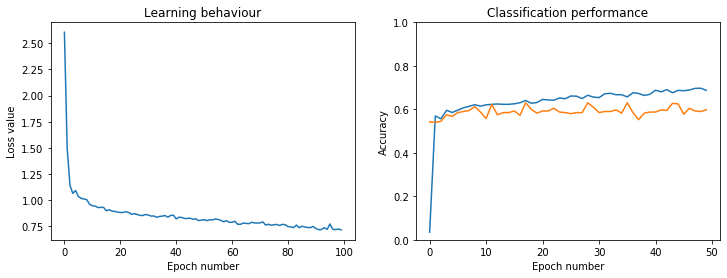

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].set_title('Learning behaviour')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Loss value')
ax[0].plot(losses);

ax[1].set_title('Classification performance')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Accuracy')
ax[1].plot(training_accuracy, label='Training')
ax[1].plot(testing_accuracy, label='Testing');
ax[1].set_ylim([0,1]);

Train: acc = 73.0%, f1 = 0.73
Test:  acc = 62.0%, f1 = 0.62


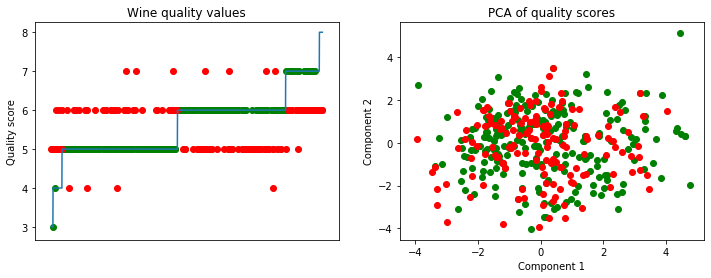

In [19]:
model.eval()

y_predict = model(X_test)
y_predict = torch.argmax(y_predict, dim=1)

correct_idx = (y_predict == y_test).to(home).detach().numpy()
incorrect_idx = (y_predict != y_test).to(home).detach().numpy()

y_predict = y_predict.to(home).detach().numpy()

y_predict_train = model(X_train)
y_predict_train = torch.argmax(y_predict_train, dim=1).to(home).detach().numpy()

score(y_train.to(home), y_predict_train, y_test.to(home), y_predict)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].set_title('Wine quality values')
ax[0].set_ylabel('Quality score')
ax[0].set_xticks([])
ax[0].plot(np.arange(NUM_WINES), data[:, QUALITY])

ax[0].scatter(idx_trnsfrmd[idx_test[correct_idx]], y_predict[correct_idx], c='green');
ax[0].scatter(idx_trnsfrmd[idx_test[incorrect_idx]], y_predict[incorrect_idx], c='red');

ax[1].set_title('PCA of quality scores')
ax[1].set_xlabel("Component 1")
ax[1].set_ylabel("Component 2")
ax[1].scatter(data_pca[idx_test[correct_idx], 0], data_pca[idx_test[correct_idx], 1], c='green');
ax[1].scatter(data_pca[idx_test[incorrect_idx], 0], data_pca[idx_test[incorrect_idx], 1], c='red');
